In [43]:

import readgadget as rg 
import matplotlib.gridspec as gridspec
from matplotlib import style
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import cKDTree
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
from scipy.ndimage import gaussian_filter

In [109]:
def cent_h(X):

    
    # 构建 KD 树
    tree = cKDTree(X)  

    # 为每个点查询最近的30个邻居点
    dist, ind = tree.query(X, k=60)  

    # 计算局部密度
    epsilon = 1e-5
    rho = 1 / (dist + epsilon).sum(axis=1)

    # 密度最大值点的索引
    densest_idx = np.argmax(rho)

    return X[densest_idx]

def read(runpath ,i):
    snapfname = runpath + 'snapshot_' + str(i).zfill(3) 
    phalo = rg.readsnap(snapfname, 'pos', 'dm')
    idhalo = rg.readsnap(snapfname, 'pid', 'dm')
    pdisk = rg.readsnap(snapfname, 'pos', 'disk')
    pbulge = rg.readsnap(snapfname, 'pos', 'bulge')
    idisk = rg.readsnap(snapfname, 'pid', 'disk')
    ibulge = rg.readsnap(snapfname, 'pid', 'bulge')
    vbulge = rg.readsnap(snapfname, 'vel', 'bulge')
    
    '''pmw_halo = phalo[(idhalo > 0) & (idhalo <= 1000000/2)]
    pm31_halo = phalo[(idhalo > 1000000/2) & (idhalo <= 2500000/2)]
    plmc_halo = phalo[(idhalo > 1250000) & (idhalo <= 1300000)]
    
    pmw_disk = pdisk[(idisk > 1300000) & (idisk <= 1650000)]
    pmw_bulge = pbulge[(ibulge > 2250000) & (ibulge <= 2300000)]
    
    pm31_disk = pdisk[(idisk > 1650000) & (idisk <= 2250000)]    
    pm31_bulge = pbulge[(ibulge > 2300000) & (ibulge <= 2395000)]
    vm31_bulge = vbulge[(ibulge > 2300000) & (ibulge <= 2395000)]
    
    plmc_bulge = pbulge[(ibulge > 2395000) & (ibulge <= 2420000)]
    vlmc_bulge = vbulge[(ibulge > 2395000) & (ibulge <= 2420000)]#light lmc'''
    
    pmw_halo = phalo[(idhalo > 0) & (idhalo <= 1000000/2)]
    pm31_halo = phalo[(idhalo > 1000000/2) & (idhalo <= 2500000/2)]
    plmc_halo = phalo[(idhalo > 1250000) & (idhalo <= 1320000)]
    
    pmw_disk = pdisk[(idisk > 1320000) & (idisk <= 1670000)]
    pmw_bulge = pbulge[(ibulge > 2270000) & (ibulge <= 2320000)]
    
    pm31_disk = pdisk[(idisk > 1670000) & (idisk <= 2270000)]    
    pm31_bulge = pbulge[(ibulge > 2320000) & (ibulge <= 2415000)]
    vm31_bulge = vbulge[(ibulge > 2320000) & (ibulge <= 2415000)]
    
    plmc_bulge = pbulge[(ibulge > 2415000) & (ibulge <= 2450000)]
    vlmc_bulge = vbulge[(ibulge > 2415000) & (ibulge <= 2450000)]#mid lmc'''
    
    
    '''pmw_halo = phalo[(idhalo > 0) & (idhalo <= 1000000/2)]
    pm31_halo = phalo[(idhalo > 1000000/2) & (idhalo <= 2500000/2)]
    plmc_halo = phalo[(idhalo > 1280000) & (idhalo <= 1350000)]
    
    pmw_disk = pdisk[(idisk > 1350000) & (idisk <= 1700000)]
    pmw_bulge = pbulge[(ibulge > 2300000) & (ibulge <= 2350000)]
    
    pm31_disk = pdisk[(idisk > 1700000) & (idisk <= 2300000)]    
    pm31_bulge = pbulge[(ibulge > 2350000) & (ibulge <= 2445000)]
    vm31_bulge = vbulge[(ibulge > 2350000) & (ibulge <= 2445000)]
    
    plmc_bulge = pbulge[(ibulge > 2445000) & (ibulge <= 2495000)]
    vlmc_bulge = vbulge[(ibulge > 2445000) & (ibulge <= 2495000)]#heavy lmc'''
    
    cent_mw = cent_h(pmw_bulge)
    print(cent_mw)
    cent_m31 = cent_h(pm31_bulge)
    print(cent_m31)
    cent_lmc = cent_h(plmc_bulge)
    print(cent_lmc)
    #pstar = pm31_bulge - cent_m31.reshape((1, 3))
    #rr2 = ((pstar**2).sum(-1))**0.5
    #vgal2 = np.mean(vm31_bulge[rr2 <= 5., :], axis=0)
    #print(vgal2)
    r_mw_m31= cent_m31-cent_mw
    r_mw_lmc = cent_lmc-cent_mw
    r_m31_lmc = cent_lmc-cent_m31
    posdm_MW = np.r_[pmw_halo-cent_mw]
    posdm_M31 = np.r_[pm31_halo-cent_mw]
    posdm_LMC = np.r_[plmc_halo-cent_mw]
    r0 = np.array([-375.1316149740847,605.5277209737903,-278.83597703631733]) 
    v0 = np.array([37.53564320437491,-114.3816276001235,15.117831344570334])#dr3
    x_COM = r0/np.linalg.norm(r0)
    z_COM = -np.cross(r0,v0)/np.linalg.norm(np.cross(r0,v0))
    y_COM = -np.cross(x_COM,z_COM)
    print(x_COM,y_COM,z_COM)
    #坐标变化的矩阵
    A = np.array([x_COM,y_COM,z_COM])
    A = A.T
    
    posdm_MW_com = np.dot(posdm_MW, A)
    posdm_M31_com = np.dot(posdm_M31, A)
    posdm_LMC_com = np.dot(posdm_LMC, A)
    r_mw_m31_com = np.dot(r_mw_m31, A)
    r_mw_lmc_com = np.dot(r_mw_lmc, A)
    
    return posdm_MW_com, posdm_M31_com, posdm_LMC_com, r_mw_m31_com, r_mw_lmc_com


def create_density_map(pos, xlim, ylim, bins=100):
    H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=bins, range=[xlim, ylim])
    H_sigma = gaussian_filter(H, sigma=2)
    #H = H.T  # Transpose to match the orientation of the plot

    return H_sigma, xedges, yedges



In [112]:
runpath = '/home/guozx/M31/Output/low_res/DR3_lmc/'
i =0
posMW_0, posM31_0,posLMC_0,r_m31_0,r_lmc_0 = read(runpath,i)
H_0, xedges_0, yedges_0 = create_density_map(posMW_0[:, [0, 1]], [-300, 300], [-300, 300])

Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.0021618  -0.00543999  0.00177899]
[-375.13028  605.5266  -278.83322]
[ -0.61487365 -41.02209    -26.83447   ]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]


In [160]:
frames = np.arange(0, 500, 1)
results = Parallel(n_jobs=20)(delayed(read)(runpath, i) for i in frames)
r_m31 = np.array([result[3] for result in results])
r_lmc = np.array([result[4] for result in results])
posMW = np.array([result[0] for result in results])
print(r_m31.shape)

8336.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8336.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8337.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
8337.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions


8337.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8338.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities


8338.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8338.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modu

[-0.0021618  -0.00543999  0.00177899]
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities


8339.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[-375.13028  605.5266  -278.83322]
[ 0.05476503 -0.15261213 -0.22394052]
[ 0.03580377 -0.04737283 -0.25276297]


8339.75s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[ 0.06885532 -0.3351641  -0.31154224]
[ 0.03346265 -0.41552192 -0.39251179]
Returning DM    Positions
Returning DM    Particle IDs
[ -0.61487365 -41.02209    -26.83447   ]
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
8340.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[ 0.03325323 -0.66739184 -0.47317925]


8340.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities


8340.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[ 0.09639665 -0.9010134  -0.53167146]
[-373.85623  600.7827  -278.3976 ]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.1063058  -1.56332    -0.74030066]
[-374.5595   603.0604  -278.69983]
[ 0.07521614 -1.2646794  -0.6495123 ]


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[-372.99652  598.55536 -278.0137 ]
[-372.28488  596.2633  -277.6445 ]
[-0.13303047 -1.8577282  -0.79202   ]


8341.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[ -3.3073277 -49.07816   -18.19122  ]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[ -1.944871 -45.19741  -22.607082]
[ -4.678749 -52.768013 -13.747187]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[-0.24279194 -2.3552134  -0.8453931 ]
[ -5.9869843 -56.1274     -9.190545 ]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-371.59595  594.05    -277.3235 ]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities


8341.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[-370.8509   591.843   -277.15448]
[-0.32407072 -2.9206257  -0.9060296 ]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
[ -7.3387594 -59.252842   -4.617857 ]
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.3713825  -3.3075926  -0.90729827]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-369.3735   587.253   -276.62234]


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[-370.0996   589.54224 -276.85162]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.68689394 -4.189414   -0.97595036]


8342.10s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[-8.654286e+00 -6.217096e+01 -1.686722e-02]
[-0.7951699 -4.754124  -0.9829924]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-368.63974  585.0485  -276.2827 ]
[-0.6068422 -3.8171117 -0.934045 ]
[-0.9886299 -5.22743   -0.9389289]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
[ -9.94601   -64.856285    4.5186105]
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-11.131365 -67.3485     9.055095]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-367.86285  582.7901  -275.97025]
[-1.154836   -5.748864   -0.95040303]
[-12.344189  -69.68682    13.5922985]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]


8342.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[-1.2538859 -6.149251  -0.9392361]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-1.2310677 -6.6172004 -0.8996025]
[-13.438359 -71.7292    18.063639]
[-1.396788  -7.2963195 -0.8860831]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-366.0781   577.06726 -275.25345]
[-1.5771804  -7.7672744  -0.83838475]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-366.80722  579.28375 -275.55273]


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
8343.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[-1.6408721 -8.278638  -0.7040679]
[-364.49274  572.56525 -274.76227]
[-363.75024  570.239   -274.41455]
[-365.33752  574.8282  -275.01068]
[-362.88794  567.82263 -274.06616]
[-2.0256658 -9.434781  -0.531809 ]
[-16.156128 -76.034256  29.08122 ]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
Returning DM    Positions
[-15.052324 -74.421074  24.7294  ]
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-1.7570379  -8.995293   -0.68827575]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities


8343.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[-362.32626  565.65094 -273.6445 ]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-18.116405 -78.88805   37.600204]
[-2.1390166 -9.856515  -0.5366774]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-361.57712  563.4135  -273.3404 ]
[-19.049923 -80.23725   41.66704 ]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-19.94937 -81.47043  45.79187]
[-17.197355 -77.51192   33.34859 ]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-0.49040497  0.79159899 -0.36451886] [0.

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[ -2.7547047  -12.130923    -0.04703611]
[-22.646725 -84.2453    57.605297]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-356.94403  549.7385  -271.43863]
[-23.52876 -85.01238  61.40875]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities


8344.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[-357.72534  552.0066  -271.77533]
[ -3.0900078  -13.034251     0.19863537]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[ -3.302621  -13.929655    0.3418944]
[ -3.5242229  -14.364463     0.53026277]
[-25.196672 -86.32816   68.821724]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-24.380697 -85.665924  65.15107 ]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
Returning DM    Positions
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Particle IDs
[ -3.0675495  -12.486378     0.03164109]
Returning DISK  Positions
Returning DISK  Positions
Returning BULGE Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning DISK  Particle IDs
Returning BULGE Par

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[-350.5209   529.92633 -268.56998]
[ -5.7073874 -19.049135    2.3103805]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-28.243017 -88.46098   82.76105 ]
[-30.407337 -89.62193   92.689514]
[-29.751461 -89.26768   89.398705]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[ -5.956681  -19.500053    2.4201183]
[-347.39307  520.5651  -267.28354]
[-348.19574  522.98096 -267.6286

In [166]:
print(posMW[ : ,:, [0, 1]].shape)

(500, 500000, 2)


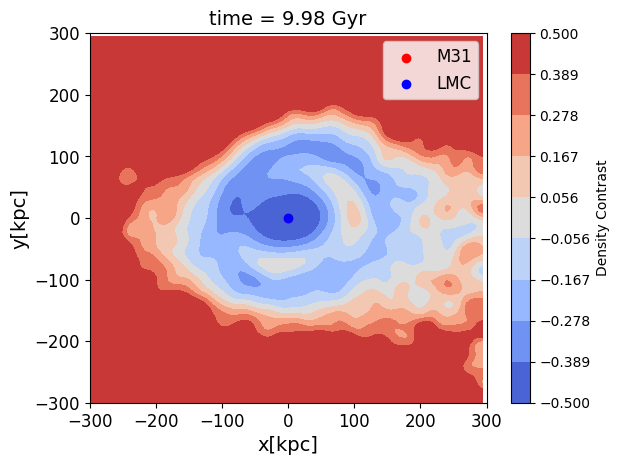

In [169]:

'''H, xedges, yedges = create_density_map(posMW[:, [0, 1]], [-300, 300], [-300, 300])
delta_H = H/H_0-1

delta_H = np.where(delta_H > 0.5, 0.5, delta_H)

print(delta_H)'''
fig, ax = plt.subplots()
# 初始化 color bar 的范围
placeholder_data = np.zeros((10, 10))  # 假设初始网格为 10x10
xedges = np.linspace(-300, 300, 11)  # 对应 x 轴的边界
yedges = np.linspace(-300, 300, 11)  # 对应 y 轴的边界

# 初始化 contourf 图
cs = ax.contourf(xedges[:-1], yedges[:-1], placeholder_data, cmap='coolwarm', levels=cbar_levels)

# 添加 color bar
cbar = fig.colorbar(cs, ax=ax)
cbar.set_label('Density Contrast') # 设置 color bar 标签

def update(frame):
    ax.clear()
    H, xedges, yedges = create_density_map(posMW[ frame ,:, [0, 1]].T, [-300, 300], [-300, 300])
    delta_H = H/H_0-1 
    delta_H = np.where(delta_H > 0.5, 0.5, delta_H)
    delta_H = np.where(delta_H < -0.5, -0.5, delta_H)
    cs=ax.contourf(xedges[:-1], yedges[:-1], delta_H, cmap='coolwarm', levels=cbar_levels)
    ax.scatter(r_m31[frame,0], r_m31[frame,1],  c='r', label='M31')
    ax.scatter(r_lmc[frame,0], r_lmc[frame,1],c='b', label='LMC')
    ax.set_xlabel('x[kpc]',fontsize=14)
    ax.set_ylabel('y[kpc]',fontsize=14)
    ax.set_xlim(-300, 300)
    ax.set_ylim(-300, 300)
    ax.tick_params(axis='both', which='major', labelsize=12)
    #保留两位小数title, 题目是时间
    ax.set_title(f'time = {frame / 50:.2f} Gyr', fontsize=14)
    
    ax.legend(fontsize=12)

ani = FuncAnimation(fig, update, frames=len(r_m31),  repeat=False)
ani.save('wake.gif', writer='pillow', fps=15)

# 在 Jupyter Notebook 中显示动画
plt.show()



In [ ]:
r_m31 = np.array([result[3] for result in results])
r_lmc = np.array([result[4] for result in results])
posMW = np.array([result[0] for result in results])

print(posMW.shape)

(500, 500000, 3)
